In [1]:
import gc,sys
import pdb

#pdb.set_trace()
from tqdm import tqdm

import os, mlflow, mlflow.pytorch
import __init__

from transformation.gp_cpab import gp_cpab
from transformation.configManager import configManager
from extra.utilities import *
from extra.dataLoaderDiffeo import *
from extra.LossFunctionsAlternatives import LossFunctionsAlternatives
from extra.Automatic_Report import Generate_Automatic_Report
from transformation.libcpab.libcpab.pytorch.interpolation import interpolate1D

/home/kvr226/miniconda3/envs/PGM_latent_alignment/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[KeOps] Warning : 
    The default C++ compiler could not be found on your system.
    You need to either define the CXX environment variable or a symlink to the g++ command.
    For example if g++-8 is the command you can do
      import os
      os.environ['CXX'] = 'g++-8'
    
[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [2]:
import argparse; import sys; sys.argv=['']; del sys
import math

def define_prior_init(channels, space='log'):
    prior_init = []
    base_alpha = channels-2

    if space=='log':
        #prior_init = [math.log(1e-6)]*channels
        prior_init = [math.log(1e-6), *([ math.log(1/base_alpha) ]*base_alpha)]
    else:
        # Current Approach
        #prior_init = [0.0, *([1/base_alpha]*base_alpha)]
        #prior_init = [0.0, 0.0, *([1/base_alpha]*base_alpha)]


        # Approach A for avoiding flat landscape in the optimization - avoiding local optima
        prior_init = [1.0, 0.0, *([0.0]*base_alpha) ]

    return prior_init


def argparser():
    """ Argument parser for the main script """
    parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    # CPAB Setup for Gaussian Process Interpolation
    gpsetup = parser.add_argument_group('GPSetup')
    gpsetup.add_argument('--Task', type=int, default = 4, help='Amount of channels in multitask-gp estimator')
    gpsetup.add_argument('--Initialization', type=list, default = define_prior_init(4, space='default'), help='multitaks-gp initialization') # before it was 19 and works good in current setup with uniform distributed values in prior
    gpsetup.add_argument('--Lengthscale', type=float, default = 0.5, help='lengthscale on square-exponential kernel') # *** 0.5 *** #0.25, #0.5 + init gives better for 2 gaps case, # 1.25
    gpsetup.add_argument('--noise_constraint', type=list, default = [1e-3,1e-1], help='noise constrain -- [lower_bound, upper_bound]') #16
    gpsetup.add_argument('--Option', type=str, default = 'multitask', help='noise constrain') #16

    # Paths to use
    paths = parser.add_argument_group('Paths')
    paths.add_argument('--path_orig', type=str, default="../../data/orig_3aa.fasta", help='original sequence to deform')    #orig_3aa.fasta orig_3aag.fasta
    paths.add_argument('--path_target', type=list, default=[
                                                "../../data/ref_3aa1g_test.aln",
                                                "../../data/ref_3aa2g_test.aln",
                                                "../../data/ref_3aa3g_test.aln",
                                                "../../data/ref_3aa4g_test.aln",
                                                "../../data/ref_3aa6g_test.aln"], 
                                                help='Reference sequence as my desired output')
    paths.add_argument('--path_preexist_linear', type=str, default="../../models/CPABlinear4.pth", help='prebuilt model using linear case') 
    paths.add_argument('--path_preexist_gp', type=str, default="../../models/CPABGPB4.pth", help='prebuilt model using gp case')
    paths.add_argument('--path_automated_report', type=str, default="../../Results", help='path to save automatic report') 
    paths.add_argument('--logdir', type=str, default="../../Results", help='where to store results')
    
    # CPAB features
    cpab = parser.add_argument_group('CPAB')
    cpab.add_argument('--device', type=str, default="cpu", help='device')
    cpab.add_argument('--modeflag', type=str, default="1D", help='dimensionality of tesselation')
    cpab.add_argument('--window_grid', type=int, default=64, help='number of tesselation cells') #6
    cpab.add_argument('--channels', type=int, default=64, help='amount of channels for estimation --deprecated')
    cpab.add_argument('--interpolation_type', type=str, default="GP", help='type of interpolation between maps') 

    # Optimization
    opt = parser.add_argument_group('Optimization')
    opt.add_argument('--lr', type=float, default=0.1, help='learning rate') #0.01, # 0.00001 just for testing the behavior for non init thetas
    opt.add_argument('--weight_decay', type=float, default=0.0004, help='L2 regularization')
    opt.add_argument('--maxiter', type=int, default=500, help='max number of epochs') #500 iters or less
    opt.add_argument('--lossfunctmetric', type=str, default='Soft_Label_KLD', help='initial loss function') # 'JSD','Soft_Label_KLD', 'SKL'

    # LogosPlot
    logos = parser.add_argument_group('logos')
    logos.add_argument('--scale_factor', type=int, default=10, help='scale factor')
    logos.add_argument('--mode', type=str, default='see_train', help='mode') 

    # Parse and return
    args = parser.parse_args()
    return args

In [3]:
print(__package__)
args = argparser()
'''---------------------------------------------------------'''
std = configManager(args)


device = std.parserinfo('device')
modeflag = std.parserinfo('modeflag')
window_grid = std.parserinfo('window_grid')
channels = std.parserinfo('channels')
option = std.parserinfo('Option')
lossmetric = std.parserinfo('lossfunctmetric')

path = std.parserinfo('path_orig')
path_MSA_test = std.parserinfo('path_target')#PathMSAref4t
path_preexist_model = std.parserinfo('path_preexist_linear')
path_preexist_modelGP = std.parserinfo('path_preexist_gp')

pathX123 = std.parserinfo('path_automated_report')
indexlogolinear = '_LI_3aa9g_padd'
indexlogoGP = '_GP_3aa9g_padd'
indexoutputT = 'debugging_cpab_domains.txt' #'results_3aa_Inverse_direct.txt'
#self.config, self.constrain, self.tasks, self.interpolation_type, self.option 
gp_params = std.get_config_vals(['noise_constraint','Task','interpolation_type','Option','Lengthscale','Initialization'])
print('Ok')
padding_criteria = 'padding_weights'  # 'padding_weights', 'none'

        
#self.stn = get_transformer(ST_type)(ndim, config, backend='pytorch', device=dev, zero_boundary=False,
#                                          volume_perservation=False, override=False, argparser_gpdata = gp_params)


None
Ok


/home/kvr226/Explicit_Disentanglement_Molecules/src/gp_cpab/src/transformation/configManager.py:18: DeprecationWarning: The dpath.util package is being deprecated. All util functions have been moved to dpath package top level.
  return dpath.util.get(self.config.get(), key)


In [4]:

def padding_strategy(input, target, alphabet, c2i, gap_token = '.'):
    import math

    # assuming a tensor of batch x aminos x onehot_vector, we get the difference by reducing 
    # the difference between the input and target in terms of aminoacid differences, the we 
    # use such shift to fill the input with gaps in one hot fassion
    diff_length = abs(input.shape[1]-target.shape[1])
    gap_diff  = torch.nn.functional.one_hot(torch.tensor([c2i[gap_token]]),num_classes=len(alphabet)).repeat(1,diff_length,1)
    input_amp = torch.cat([input,gap_diff],dim=1)
    print(f'amplified input with gaps inclusion: \n\n{input_amp}')
    return input_amp






In [5]:
import pandas as pd
from extra.logomakers import logomaker_plots 

#def plot_logos_probs(x1_trans, alphabets, folderpath = pathfolder, name = path):  
def plot_logos_probs(x1_trans, alphabets, **kargs): #folderpath = pathfolder, name = path):  
    #from logomakers import logomaker_plots  


    alphabets_logo = [ i if i!='-' else 'X' for i in alphabets] 
    x1_trans_logo_input = df_construction_aas([ x1_trans.detach().numpy() ]*500, x1_trans.shape, alphabets_logo)
    best = logomaker_plots.plotlogos(x1_trans_logo_input[x1_trans_logo_input.columns.tolist()] )

    return best

In [6]:
print(__package__)
from tensorboardX import SummaryWriter
import time, os, datetime
#from src.extra.experiment_utilities import *

  
#writer = SummaryWriter(log_dir=logdir)

def transform_grid(data, T, theta):

    aa_universe = data.shape[-2]
    channels = data.shape[-1]
    batch_size = data.shape[0]

    # get grid partitions / uniform grid / gap symbol in one hot fashion
    grid_partitions = 1./(aa_universe-1)
    uniform_grid= T.uniform_meshgrid([aa_universe,aa_universe]).repeat(batch_size,1,1)
    grid_t_no_expansion = T.transform_grid(uniform_grid, theta)
    return grid_t_no_expansion

def gaussian_negative_log_likelihood(predictions, targets, variance=torch.tensor(0.1)):
    #import ipdb; ipdb.set_trace()
    # Compute the mean squared error
    mse_loss = F.mse_loss(predictions, targets)
    
    # Compute the negative log-likelihood (equivalent to MSE loss for Gaussian with fixed variance)
    nll = 0.5 * mse_loss / variance + 0.5 * torch.log(2 * math.pi * variance)
    
    return nll.mean()  # Take the mean over the elements of the tensor

def optimization_setup(conf, theta_est, theta_est_GP, c2i, i2c, i2i, keys = ['lr','weight_decay','maxiter']):
    '''lr=0.01 is the best one so far for linear interpolation and gp'''
        
    lr, wd, maxiter = conf.get_config_vals(keys)

    optimizer = torch.optim.AdamW([theta_est], lr=lr) #, weight_decay=wd)
    optimizerGP = torch.optim.AdamW([theta_est_GP], lr=lr)

    loss_function = LossFunctionsAlternatives()
    loss_function.get_dictionaries_to_mask_data(c2i, i2c, i2i)

    return lr, wd, maxiter, optimizer, optimizerGP, loss_function

def training_optimal_theta(T, opt, maxiter, x1, ref_msa, theta_est, alphabets, c2i, inverse):

    #import ipdb; ipdb.set_trace()
    import torch.nn.functional as F

    optimal_grid = infer_optimal_grid(ref_msa, alphabets, c2i, T, gap_token='-')

    pb = tqdm(desc='Alignment of samples', unit='iters', total=maxiter)
    for i in range(maxiter):
        opt.zero_grad()

        if inverse == True:
            opt_est = -theta_est
            grid_trans = transform_grid(x1, T, opt_est)
            loss = gaussian_negative_log_likelihood(grid_trans, optimal_grid)
            #loss = F.kl_div(grid_trans, optimal_grid)


        loss.backward()
        opt.step()

        gc.collect()
        torch.cuda.empty_cache()
        #torch.save(theta_est, path_preexist_model)

        pb.update()
        pb.set_postfix({'loss': str(loss.item())})

    pb.close()

    #import ipdb; ipdb.set_trace()
    return theta_est


def define_thetas(T):
    theta_ref = torch.autograd.Variable(T.identity(1, epsilon=1e-6), requires_grad=True)
    theta_est = torch.autograd.Variable(theta_ref.clone(), requires_grad=True)
    theta_est_GP = torch.autograd.Variable(theta_ref.clone(), requires_grad=True)
    return theta_ref, theta_est, theta_est_GP


def infer_optimal_grid(data,alphabet, c2i, T, gap_token='-'):
    # get the dimensions
    #import ipdb; ipdb.set_trace()
    aa_universe = data.shape[-2]
    channels = data.shape[-1]
    batch_size = data.shape[0]

    # get grid partitions / uniform grid / gap symbol in one hot fashion
    grid_partitions = 1./(aa_universe-1)
    uniform_grid= T.uniform_meshgrid([aa_universe,aa_universe]).repeat(batch_size,1,1)
    gap_one_hot_val = torch.nn.functional.one_hot(torch.tensor([c2i[gap_token]]),
                                                  num_classes=len(alphabet))
    
    # get the idxs that corresponds to gaps using masking
    all_true_mask = torch.all(data[0] == gap_one_hot_val, dim=1)
    idxs_gaps = torch.nonzero(all_true_mask.view(-1), as_tuple=False)
    # data[:,idxs_gaps.flatten()] for sanity check

    # generate all the set of indexes.shape
    all_idxs = torch.arange(aa_universe).reshape(-1,1)

    # obtaining the idxs that are not belonging to the gaps
    idxs_nogaps = all_idxs[~torch.any(all_idxs[:, None] == idxs_gaps, dim=1)]
    # data[:,idxs_nogaps.flatten()] for sanity check

    # get the infered optimal grid to follow as target on the optimization
    aa_vals_in_grid = uniform_grid[:,:,idxs_nogaps]
    diff = aa_universe-aa_vals_in_grid.shape[-1]
    remaining=torch.linspace(1, 1+grid_partitions*diff, diff+1)[1:].repeat(1,1,1)
    return torch.cat([aa_vals_in_grid,remaining],dim=-1)

import matplotlib.gridspec as gridspec
import logomaker
def create_gridSpec_graphs(ncols=4,nrows=2,figsize=(25,12)):
        fig = plt.figure(figsize=figsize) #(constrained_layout=True)
        gs = gridspec.GridSpec(ncols=ncols, nrows=nrows, figure=fig, hspace=1.5, wspace=0.8)
        for i in range(0, nrows):
            for j in range(0,ncols):
                fig.add_subplot(gs[i, j])
        return fig, gs
    
def plot_logos_probs(x1_trans, alphabets, **kargs): #folderpath = pathfolder, name = path):  
    #from logomakers import logomaker_plots  
    if 'figsize' in kargs:
        figsize = kargs['figsize']

    fig, gs = create_gridSpec_graphs(ncols=1,nrows=1, figsize=figsize)

    alphabets_logo = [ i if i!='-' else 'X' for i in alphabets] 
    x1_trans_logo_input = df_construction_aas([ x1_trans.detach().cpu().numpy() ], x1_trans.shape, alphabets_logo)
    #best = logomaker_plots.plotlogos(x1_trans_logo_input[x1_trans_logo_input.columns.tolist()] )

    fig.axes[0].get_xaxis().set_visible(False)
    fig.axes[0].get_yaxis().set_visible(False)
    fig.axes[0].axis('off') 
        

    logomaker.Logo(x1_trans_logo_input,
                          color_scheme = 'NajafabadiEtAl2017',
                          ax = fig.axes[0],
                          figsize=figsize, show_spines=False)



def flatten_list_of_lists(list_bag):
    return sum(list_bag, [])

def plot_Ts_from_preds(tensors, alphabet, figsize = (15,14), show_axis=True):


    n_rows = int(len(tensors)/3)
    fig, gs = create_gridSpec_graphs(ncols=3,nrows=n_rows, figsize=figsize) #; fig.suptitle('MSA', fontsize='large')

    alphabets_logo = [ i if i!='-' else '?' for i in alphabet]

    for cont, x_aligned in enumerate(tensors):
        domain_info_df = df_construction_aas([ x_aligned.detach().numpy() ], 
                                             x_aligned.shape, 
                                             alphabets_logo)

        if show_axis == False:
            fig.axes[cont].get_xaxis().set_visible(False)
            fig.axes[cont].get_yaxis().set_visible(False)
            fig.axes[cont].axis('off') 
        

        logomaker.Logo(domain_info_df,
                          color_scheme = 'NajafabadiEtAl2017',
                          ax = fig.axes[cont],
                          figsize=figsize, show_spines=False)


def get_transformation_setup(alphabet, path_input, path_target, T):

        # Reference Information - how the alignment should looks like
    
    alignment, ref_msa, alphabets, c2i, i2c, i2i,seqchar = read_clustal_align_output(path_target, alphabet=alphabet)

    dataset_msa = datasetLoader(pathBLAT_data = path_input, alphabet = alphabets, enable_variable_length=True)

    x1 = padding_strategy(dataset_msa.prot_space.float(),ref_msa.float(), alphabets, c2i, gap_token = '-')





    #import ipdb; ipdb.set_trace()
    theta_ref, theta_est, theta_est_GP = define_thetas(T)

    lr, wd, maxiter, optimizer, optimizerGP, loss_function = optimization_setup(std, theta_est, theta_est_GP, 
                                                                                c2i, i2c, i2i, 
                                                                                ['lr','weight_decay','maxiter'])
    

    optimal_grid = infer_optimal_grid(ref_msa,alphabets, c2i, T, gap_token='-')



    T.interpolation_type = 'GP'

    theta_optimized = training_optimal_theta(T, optimizerGP, maxiter, x1, ref_msa, 
                                             theta_est_GP, alphabets, c2i, inverse=True)
    
    InvGP_trans, _, _ = T.spatial_transformation(x1, x1, -theta_optimized, modeflag)



    T.interpolation_type = 'linear'
    #Invlinear_trans, _, _ = T.spatial_transformation(x1, x1, -theta_optimized, modeflag)
    Dirlinear_trans, _, _ = T.spatial_transformation(x1, x1, theta_optimized, modeflag) 

    return [InvGP_trans, ref_msa, Dirlinear_trans]


None


/home/kvr226/miniconda3/envs/PGM_latent_alignment/lib/python3.8/site-packages/google/rpc/__init__.py:20: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.rpc')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  pkg_resources.declare_namespace(__name__)
/home/kvr226/miniconda3/envs/PGM_latent_alignment/lib/python3.8/site-packages/pkg_resources/__init__.py:2350: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(parent)


/home/kvr226/miniconda3/envs/PGM_latent_alignment/lib/python3.8/site-packages/torch/utils/cpp_extension.py:3: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


No CUDA runtime is found, using CUDA_HOME='/home/kvr226/miniconda3/envs/PGM_latent_alignment'


/home/kvr226/Explicit_Disentanglement_Molecules/src/gp_cpab/src/transformation/configManager.py:18: DeprecationWarning: The dpath.util package is being deprecated. All util functions have been moved to dpath package top level.
  return dpath.util.get(self.config.get(), key)


tmp
amplified input with gaps inclusion: 

tensor([[[0., 0., 1., 0.],
         [0., 1., 0., 0.],
         [0., 0., 0., 1.],
         [1., 0., 0., 0.]]])


Alignment of samples: 100%|██████████| 500/500 [01:13<00:00,  6.82iters/s, loss=-0.2323511391878128] 
/home/kvr226/Explicit_Disentanglement_Molecules/src/gp_cpab/src/transformation/libcpab/libcpab/pytorch/functions.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=dtype, device=device)


tmp
amplified input with gaps inclusion: 

tensor([[[0., 0., 1., 0.],
         [0., 1., 0., 0.],
         [0., 0., 0., 1.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.]]])


Alignment of samples: 100%|██████████| 500/500 [01:13<00:00,  6.79iters/s, loss=-0.2322400063276291] 


tmp
amplified input with gaps inclusion: 

tensor([[[0., 0., 1., 0.],
         [0., 1., 0., 0.],
         [0., 0., 0., 1.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.]]])


Alignment of samples: 100%|██████████| 500/500 [01:12<00:00,  6.94iters/s, loss=-0.2320607453584671] 


tmp
amplified input with gaps inclusion: 

tensor([[[0., 0., 1., 0.],
         [0., 1., 0., 0.],
         [0., 0., 0., 1.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.]]])


Alignment of samples: 100%|██████████| 500/500 [01:10<00:00,  7.05iters/s, loss=-0.23159921169281006]


tmp
amplified input with gaps inclusion: 

tensor([[[0., 0., 1., 0.],
         [0., 1., 0., 0.],
         [0., 0., 0., 1.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.]]])


Alignment of samples: 100%|██████████| 500/500 [01:14<00:00,  6.69iters/s, loss=-0.23123280704021454]


FROM HERE


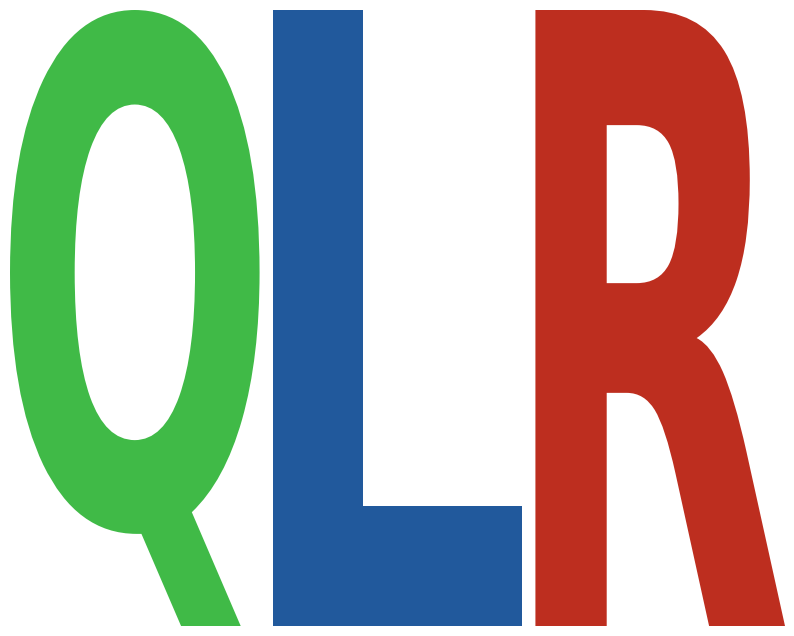

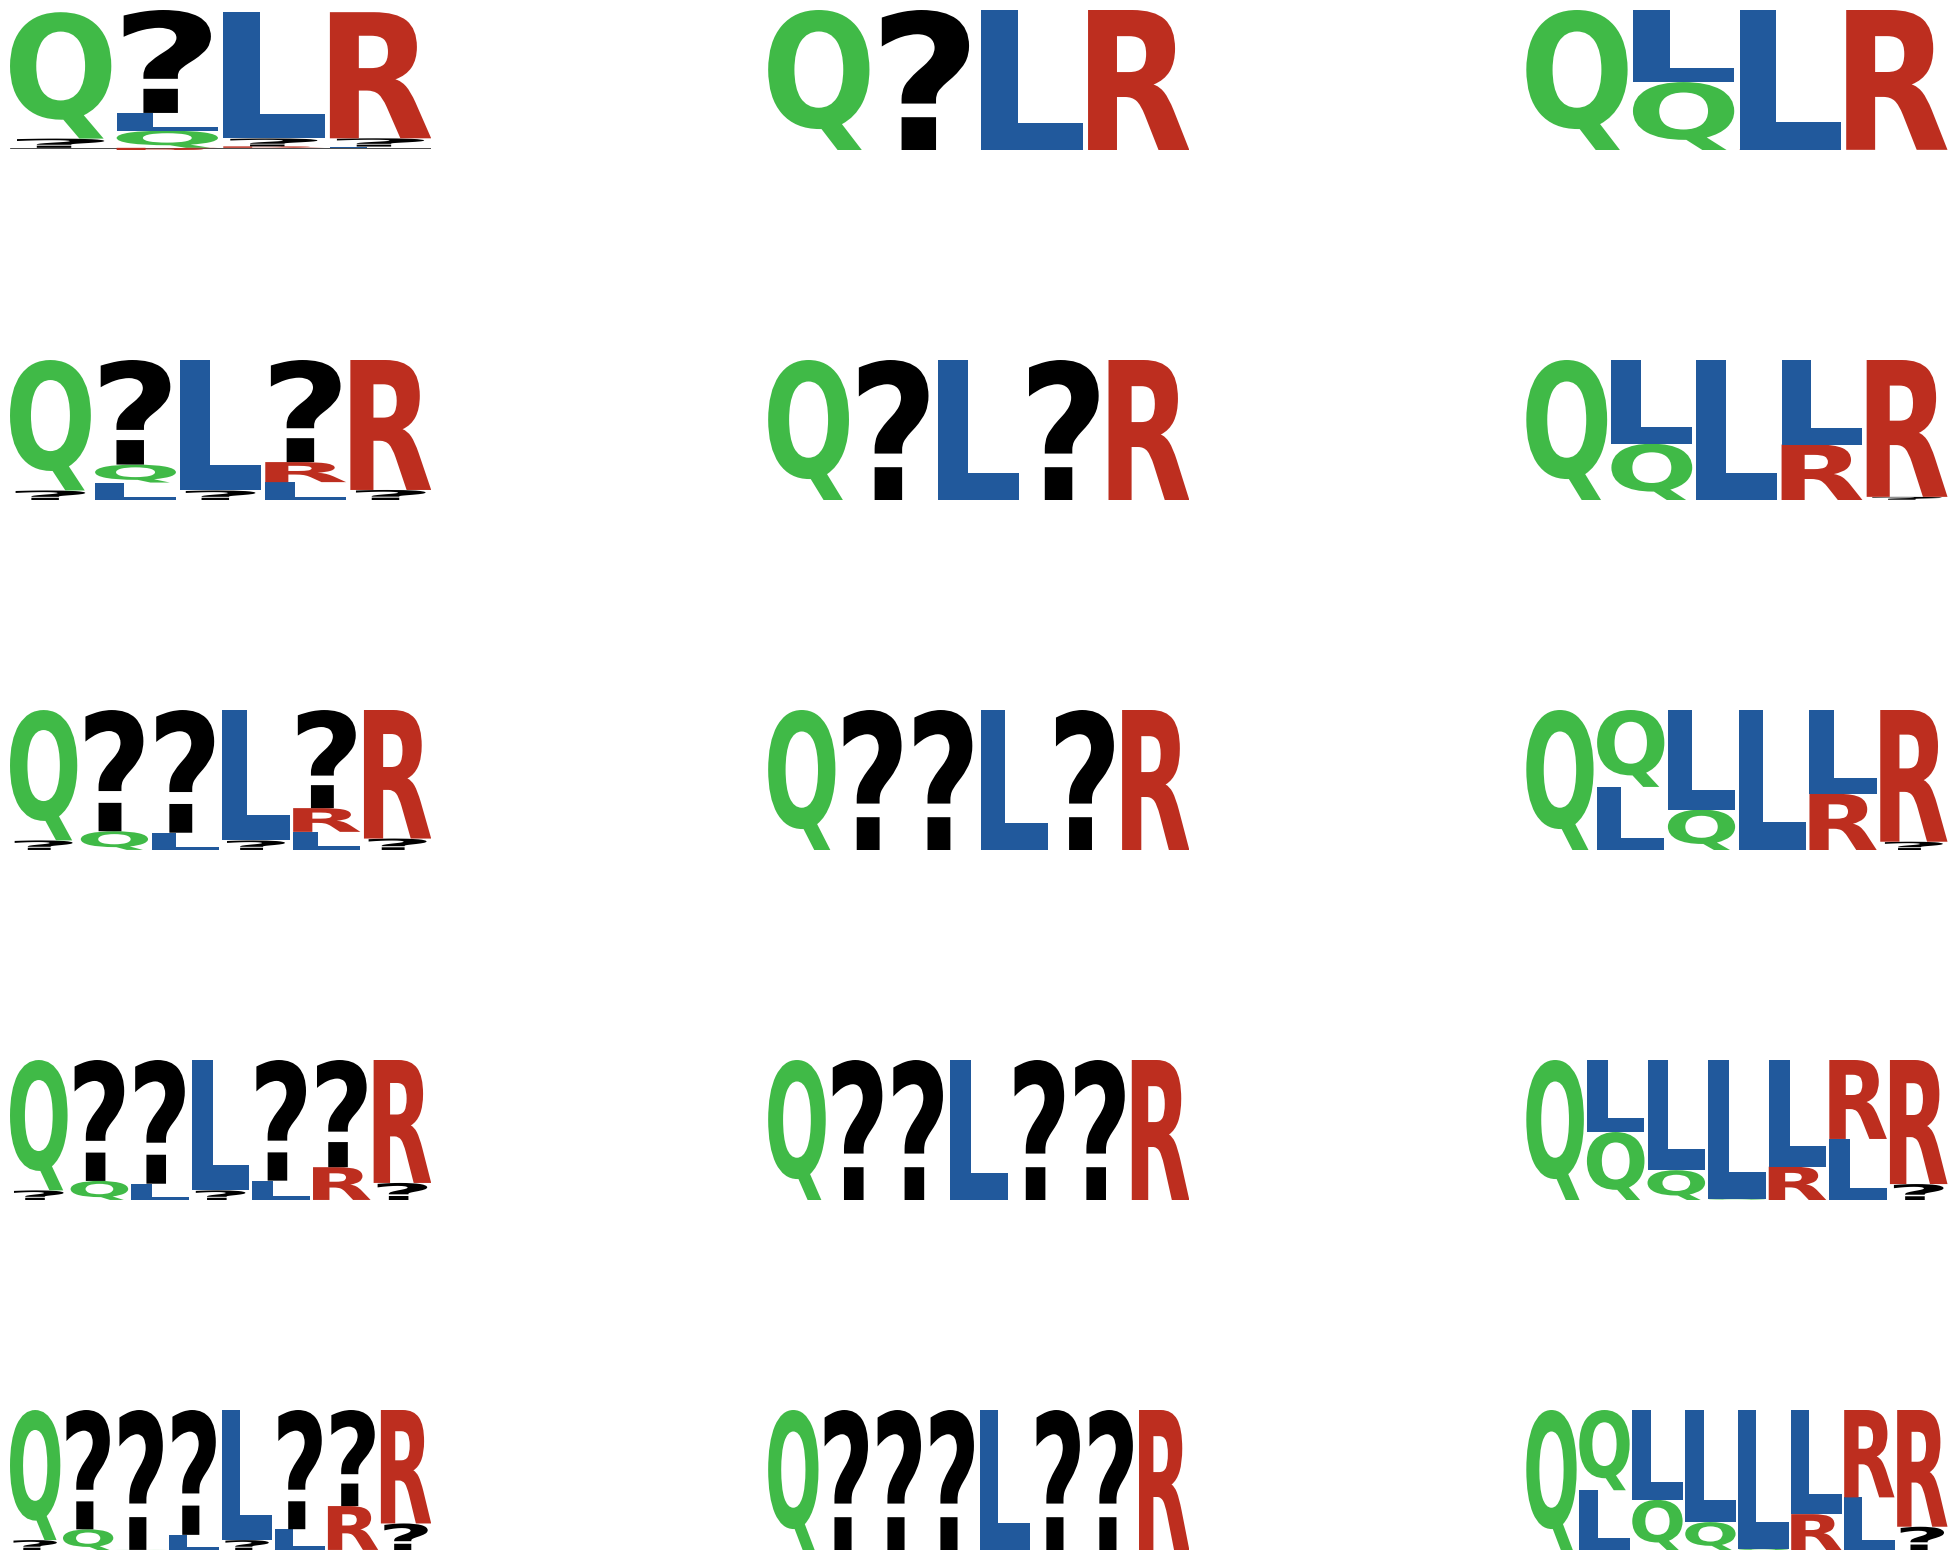

In [7]:
def main():
    #import ipdb; ipdb.set_trace()
    from transformation.gp_cpab import gp_cpab

    alph = ['-', 'L', 'Q', 'R']
    # Raw Sequences, to see if we can align the sequences somehow
    #dataset_msa = datasetLoader(pathBLAT_data = path, alphabet = alphabets, enable_variable_length=True)


    ndim = [window_grid]
    T = gp_cpab(ndim, std, backend='pytorch', device=device, zero_boundary=False,
                                            volume_perservation=False, override=False, argparser_gpdata = gp_params)        

    #print(f'transformed input using linear interpolation -theta: \n\n{Invlinear_trans}')
    #print(f'transformed input using linear interpolation theta: \n\n{Dirlinear_trans}')
    list_results = []
    dataset_msa = datasetLoader(pathBLAT_data = path, alphabet = alph, enable_variable_length=True)
    plot_logos_probs(dataset_msa.prot_space, alph, figsize=(10,8))
    
    for i in path_MSA_test:
        list_results.append( get_transformation_setup(alph, path, i, T)  )

    list_results = flatten_list_of_lists(list_results)

    import matplotlib.pyplot as plt
 
    #list1 = [InvGP_trans, Invlinear_trans, Dirlinear_trans]
    #list2 = [Invlinear_trans, InvGP_trans,  Dirlinear_trans]
    #list3 = [Invlinear_trans, InvGP_trans,  Dirlinear_trans]
    #list4 = [InvGP_trans,  Dirlinear_trans, Invlinear_trans ]


    plot_Ts_from_preds( list_results, #[*list1, *list2, *list3, *list4], 
                    alph, figsize = (25,20), show_axis=False)

    print('FROM HERE')

    
main()